In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

# Step 2: Import the module
import utils
from engine import train_one_epoch, evaluate

Cloning into 'vision'...
remote: Enumerating objects: 535191, done.
remote: Counting objects: 100% (48801/48801), done.
remote: Compressing objects: 100% (2261/2261), done.
remote: Total 535191 (delta 46573), reused 48593 (delta 46456), pack-reused 486390
Receiving objects: 100% (535191/535191), 1.00 GiB | 26.47 MiB/s, done.
Resolving deltas: 100% (499808/499808), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import cv2, os, glob, json, csv, PIL
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Model
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
!unzip '/content/drive/MyDrive/Machine_Learning/Number_Plate.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Number_Plate/Image/CarLongPlateGen2838.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2839.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen284.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2840.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2841.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2842.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2843.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2844.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2845.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2846.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2847.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2848.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2849.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen285.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2850.jpg  
  inflating: Number_Plate/Image/CarLongPlateGen2851.jpg  
  inflating: Number_Pla

In [4]:
img_path = '/content/Number_Plate/Image'
data = pd.read_csv('/content/Number_Plate/Data.csv')

img_file = os.listdir(os.path.join(img_path))
print(len(img_file), img_file[0])
data.head()

8420 CarLongPlateGen63.jpg


,File,X_min,Y_min,X_max,Y_max
0,boderngoaigiao0.jpg,252,135,302,144
1,boderngoaigiao1.jpg,262,173,384,210
2,boderngoaigiao10.jpg,75,69,85,75
3,boderngoaigiao10.jpg,138,57,144,60
4,boderngoaigiao11.jpg,186,203,251,225


In [42]:
class PlateImagesDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.data = data
        self.height = height
        self.width = width

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.jpg_files = [image for image in os.listdir(files_dir) if image[-4:]=='.jpg']

        self.imgs = []
        for i, image in enumerate(self.jpg_files):
            if i == 500:
                break
            self.imgs.append(image)
        for file in os.listdir(files_dir):
          if file[-4:]=='.csv':
            self.data = pd.read_csv(file)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)
        data_name = self.data.iloc[:, 0]
        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        boxes = []
        labels = []

        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        # box coordinates for csv data are extracted and corrected for image size given
        for index, value in data_name.items():
          if img_name == value:
            labels.append(1)    #Just have one label is plate

            xmin = self.data.iloc[index, 1]
            xmax = self.data.iloc[index, 3]

            ymin = self.data.iloc[index, 2]
            ymax = self.data.iloc[index, 4]

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = PlateImagesDataset(img_path, 224, 224)
print('length of dataset = ', len(dataset), '\n', dataset)

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[84]
print(img.shape, '\n',target)

length of dataset =  500 
(224, 224, 3) 
 {'boxes': tensor([[ 85.4237,  47.3135, 128.1356, 103.4984]]), 'labels': tensor([1]), 'area': tensor([2399.7583]), 'iscrowd': tensor([0]), 'image_id': tensor([84])}


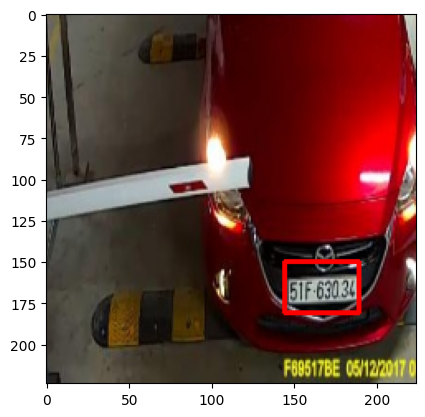

In [43]:
def plot_img_bbox(img, target):
    # plot the image and bboxes

    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Bounding boxes are defined as follows: x-min y-min width height
    plt.subplots(1,1)

    new_boxes = target['boxes'].cpu().numpy()

    for box in new_boxes:
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = cv2.rectangle(img, (int(x), int(y)), (int(x+width), int(y+height)), (255, 0, 0), thickness=2)

    plt.imshow(rect)

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[8]
plot_img_bbox(img, target)

In [7]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
# use our dataset and defined transformations
dataset = PlateImagesDataset(img_path, 224, 224, transforms= get_transform(train=True))
dataset_test = PlateImagesDataset(img_path, 224, 224, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)


# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 170MB/s]


In [11]:
# training for 10 epochs
num_epochs = 10
# Move model to the device
model.to(device)

# Assuming optimizer is already defined

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=25)
    # update the learning rate
    lr_scheduler.step()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [ 0/40]  eta: 0:03:10  lr: 0.000133  loss: 0.8417 (0.8417)  loss_classifier: 0.7215 (0.7215)  loss_box_reg: 0.0559 (0.0559)  loss_objectness: 0.0616 (0.0616)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 4.7694  data: 0.2990  max mem: 8200
Epoch: [0]  [25/40]  eta: 0:00:28  lr: 0.003335  loss: 0.2689 (0.3791)  loss_classifier: 0.1266 (0.2297)  loss_box_reg: 0.1224 (0.1034)  loss_objectness: 0.0201 (0.0410)  loss_rpn_box_reg: 0.0032 (0.0051)  time: 1.7409  data: 0.0430  max mem: 8360


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [0]  [39/40]  eta: 0:00:01  lr: 0.005000  loss: 0.1886 (0.3110)  loss_classifier: 0.0601 (0.1683)  loss_box_reg: 0.1191 (0.1079)  loss_objectness: 0.0097 (0.0303)  loss_rpn_box_reg: 0.0032 (0.0045)  time: 1.7442  data: 0.0356  max mem: 8360
Epoch: [0] Total time: 0:01:13 (1.8352 s / it)
Epoch: [1]  [ 0/40]  eta: 0:01:32  lr: 0.005000  loss: 0.1689 (0.1689)  loss_classifier: 0.0459 (0.0459)  loss_box_reg: 0.1180 (0.1180)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 2.3184  data: 0.5500  max mem: 8360
Epoch: [1]  [25/40]  eta: 0:00:28  lr: 0.005000  loss: 0.1267 (0.1368)  loss_classifier: 0.0327 (0.0348)  loss_box_reg: 0.0856 (0.0967)  loss_objectness: 0.0017 (0.0030)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 1.8586  data: 0.0371  max mem: 8360
Epoch: [1]  [39/40]  eta: 0:00:01  lr: 0.005000  loss: 0.1028 (0.1252)  loss_classifier: 0.0274 (0.0330)  loss_box_reg: 0.0694 (0.0867)  loss_objectness: 0.0019 (0.0028)  loss_rpn_box_reg: 0.0021 (0.0027)  tim

In [12]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [36]:
# pick one image from the test set
img, target = dataset_test[20]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  1
real #boxes:  1


In [37]:
print(torch_to_pil(img))

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F3D9878FD30>


EXPECTED OUTPUT


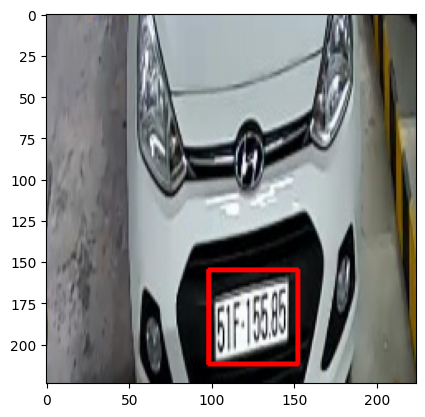

In [38]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

NMS APPLIED MODEL OUTPUT


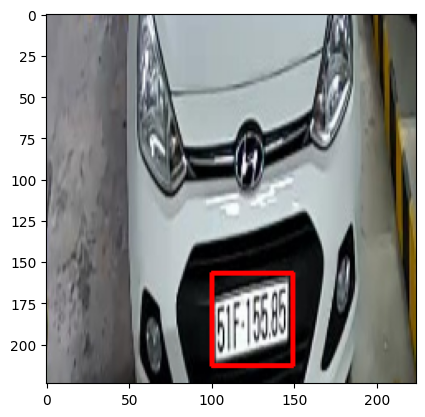

In [39]:
nms_prediction = apply_nms(prediction, iou_thresh=0.3)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT

MODEL OUTPUT



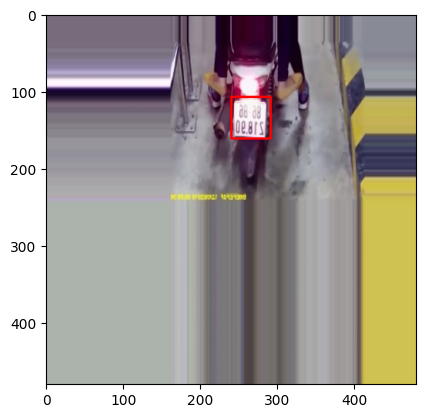

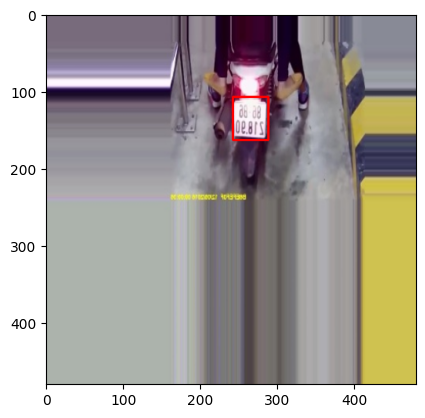

In [78]:
test_dataset = PlateImagesDataset(img_path, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[31]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.05)

plot_img_bbox(torch_to_pil(img), nms_prediction)

{'boxes': tensor([[146.9718, 216.8812, 265.6562, 278.3878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}
MODEL OUTPUT



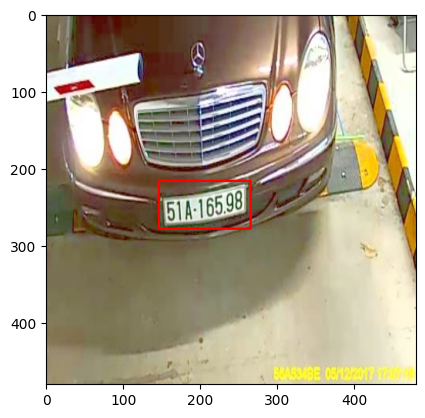

In [86]:
external_img = cv2.resize(cv2.cvtColor(cv2.imread('/content/CarLongPlateGen1283.jpg'), cv2.COLOR_BGR2RGB), (480, 480))
transform = torchtrans.ToTensor()
ex_image_tensor = transform(external_img)

model.eval()
with torch.no_grad():
    prediction = model([ex_image_tensor.to(device)])[0]
print(prediction)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(external_img, nms_prediction)

{'boxes': tensor([[101.3822,  90.6588, 358.4928, 350.4920]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9800], device='cuda:0')}
MODEL OUTPUT



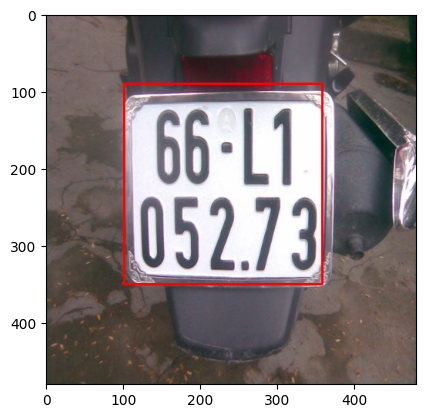

In [87]:
external_img = cv2.resize(cv2.cvtColor(cv2.imread('/content/xemayBigPlate236.jpg'), cv2.COLOR_BGR2RGB), (480, 480))
transform = torchtrans.ToTensor()
ex_image_tensor = transform(external_img)

model.eval()
with torch.no_grad():
    prediction = model([ex_image_tensor.to(device)])[0]
print(prediction)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(external_img, nms_prediction)

In [89]:
model_path = 'fastRcnn_for_plate.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_path)